# Experiment Analysis
We want to be able to go through an experiment we've conducted with our hyperparameter tuning library, pull out a certain number of models, and analyze results.

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import torch
import pickle
import models
import yaml


from datetime import datetime
from matplotlib import pyplot as plt
from ray import tune
from swdata import swDataset
from lfnets import get_loaders

## Function Definitions
Need some functions to make this code simpler - these will be build into lfnets eventually

In [10]:
## Take a list of models (length > 1 results in model ensembling), some data, and output predictions
def predict(models, data, out_shape, device):
    #initialize output array
    with torch.no_grad():
        predictions = torch.zeros(out_shape, requires_grad=False).to("cpu")
        for i in range(len(models)):
            torch.cuda.empty_cache()

            tempModel = models[i].to(device)
            tempPreds = tempModel(data.to(device)).to("cpu")
            predictions += tempPreds/len(models)
            tempModel = models[i].to("cpu")

            del tempModel
            del tempPreds

        return predictions

def convertTS(timestamp):
    rows, cols = np.shape(timestamp)
    TS = []
    for i in range(rows):
        for j in range(cols):
            clist = []
            clist.append(datetime.fromtimestamp(int(timestamp[i, j]*1e-9)))
        TS.append(clist)  
    return TS
    
def rsquared(preds, targets):
    return (1 - (torch.std((preds - targets), dim=0)**2)/(torch.std(targets, dim=0))**2).numpy()

def meanSquared(preds, targets):
    return torch.mean((preds-targets)**2, dim=0).numpy()

def meanAbs(preds, targets):
    return torch.mean(torch.abs(preds-targets)**2, dim=0).numpy()

## Load in models from all experiments and make predictions

In [11]:
## Experiment Names
exps = ['/usr/scratch/charles/data/randSearches/rand_search50/',
        '/usr/scratch/charles/data/randSearches/rand_search50/',
        '/usr/scratch/charles/data/randSearches/rand_search50/',
        '/usr/scratch/charles/data/randSearches/rand_search50/'
       ]

desc = ['No Ts', 'No Ts', 'No Ts', 'No Ts']

ensNum = [15, 10, 5, 1]
## This will be loaded in using parameters from the config file 
trainPreds = []
testPreds = []
valPreds = []

trainTS = []
testTS = []
valTS = []

trainLabels = []
testLabels = []
valLabels = []

device="cuda"

res = []

for idx in range(len(exps)):
    
    with open(exps[idx] + 'config.yml', 'r') as f:
        config = yaml.full_load(f)
    
    nModels = ensNum[idx]
    analysisDF = tune.Analysis(exps[idx]).dataframe().sort_values('mean_squared_error', axis=0)
    data = swDataset(dataFile = config["data"]["file"], split='train', valType = config["data"]["vType"],
                          normalize=config["data"]["norm"], portion=1)
    
    ## Current datasets don't include timestamp..  
    trainTS.append(convertTS(data.train_timestamp))
    testTS.append(convertTS(data.test_timestamp))
    valTS.append(convertTS(data.val_timestamp))
    
    res.append(int(np.min(np.diff(data.train_timestamp[0, :]*1e-9/60))))
    
    trainLabels.append(data.trainLabels)
    testLabels.append(data.testLabels)
    valLabels.append(data.valLabels)
    
    logdirs, cpoints = analysisDF['logdir'][0:nModels], analysisDF['training_iteration'][0:nModels]
    
    modelList = []
    for i in range(nModels):
        modelList.append(torch.load(logdirs.iloc[i] + '/checkpoint_' + str(cpoints.iloc[i]) + '/model.pt',
                                    map_location='cpu'))
    trainPreds.append(predict(modelList, data.trainData,
                         data.trainLabels.size(), device))
    testPreds.append(predict(modelList, data.testData,
                       data.testLabels.size(), device))
    valPreds.append(predict(modelList, data.valData,
                      data.valLabels.size(), device))
    
    
tnames = data.tnames

# Now that we have predictions, compute performance metrics, produce results plot and table

In [12]:
trainPerf = []
testPerf = []

metric = meanSquared

metName = 'MSE'

for i in range(len(exps)):
    B, T, nT = trainPreds[i].size()
    
    tmpTrain = []
    tmpTest = []
    
    metTrain = []
    metTest = []
    
    rsqTrain = []
    rsqTest = []
       
    for j in range(nT):
        metTrain.append(meanSquared(trainPreds[i][:, :, j], trainLabels[i][:, :, j]))
        metTest.append(meanSquared(testPreds[i][:, :, j], testLabels[i][:, :, j]))
        
        rsqTrain.append(rsquared(trainPreds[i][:, :, j], trainLabels[i][:, :, j]))
        rsqTest.append(rsquared(testPreds[i][:, :, j], testLabels[i][:, :, j]))
        
    tmpTrain.append(rsqTrain)
    tmpTrain.append(metTrain)
    
    tmpTest.append(rsqTest)
    tmpTest.append(metTest)
    
    trainPerf.append(tmpTrain)
    testPerf.append(tmpTest)


## Tabulate Performance Results

In [13]:
keys = []
trainDFList = []
testDFList = []
for i in range(len(exps)):
    keys.append('Exp ' + str(i))
    
    trainExpDF = pd.DataFrame()
    trainExpDF['Horizon(Hours)'] = np.linspace(res[i], len(trainLabels[0][0, :])*res[i], len(testLabels[0][0, :]))/60
    
    testExpDF = pd.DataFrame()
    testExpDF['Horizon(Hours)'] = np.linspace(res[i], len(trainLabels[0][0, :])*res[i], len(testLabels[0][0, :]))/60
    
    for j in range(len(tnames)):
        trainExpDF[tnames[j] + ' R^2'] = trainPerf[i][0][j]
        trainExpDF[tnames[j] + ' ' + metName] = trainPerf[i][1][j]
        
        testExpDF[tnames[j] + ' R^2'] = testPerf[i][0][j]
        testExpDF[tnames[j] + ' ' + metName] = testPerf[i][1][j]
    
    trainExpDF = trainExpDF.set_index('Horizon(Hours)')
    trainDFList.append(trainExpDF)
    
    testExpDF = testExpDF.set_index('Horizon(Hours)')
    testDFList.append(testExpDF)

trainDF = pd.concat(trainDFList, keys=keys).swaplevel().unstack().round(decimals=2)
testDF = pd.concat(testDFList, keys=keys).swaplevel().unstack().round(decimals=2)

testDF


AE R^2                   AE MSE                   AL R^2        \
                Exp 0 Exp 1 Exp 2 Exp 3  Exp 0 Exp 1 Exp 2 Exp 3  Exp 0 Exp 1   
Horizon(Hours)                                                                  
0.5              0.78  0.77  0.75  0.72   0.37  0.37  0.41  0.46   0.69  0.68   
1.0              0.68  0.68  0.66  0.64   0.53  0.54  0.56  0.60   0.59  0.59   
1.5              0.57  0.57  0.56  0.54   0.71  0.71  0.73  0.76   0.49  0.49   
2.0              0.47  0.47  0.47  0.45   0.87  0.87  0.88  0.91   0.40  0.40   
2.5              0.41  0.41  0.40  0.39   0.98  0.98  0.99  1.01   0.34  0.34   
3.0              0.36  0.36  0.36  0.34   1.05  1.05  1.06  1.08   0.31  0.31   
3.5              0.33  0.33  0.33  0.31   1.10  1.10  1.10  1.12   0.28  0.28   
4.0              0.31  0.31  0.30  0.29   1.13  1.13  1.15  1.16   0.27  0.27   
4.5              0.28  0.28  0.28  0.27   1.17  1.17  1.18  1.19   0.25  0.25   
5.0              0.27  0.27  0.26  0.25   1.20  1.20  1.21  1.22   0.24  0.24   

                ... AU MSE       SYM/H R^2                   SYM/H MSE        \
                ...  Exp 2 Exp 3     Exp 0 Exp 1 Exp 2 Exp 3     Exp 0 Exp 1   
Horizon(Hours)  ...                                                            
0.5             ...   0.42  0.45      0.88  0.88  0.86  0.88      0.26  0.25   
1.0             ...   0.53  0.55      0.86  0.86  0.84  0.87      0.30  0.30   
1.5             ...   0.62  0.65      0.83  0.84  0.82  0.84      0.36  0.35   
2.0             ...   0.71  0.74      0.80  0.81  0.79  0.82      0.42  0.41   
2.5             ...   0.78  0.81      0.77  0.78  0.76  0.79      0.48  0.47   
3.0             ...   0.84  0.88      0.75  0.75  0.74  0.76      0.54  0.53   
3.5             ...   0.89  0.93      0.73  0.73  0.72  0.74      0.58  0.57   
4.0             ...   0.93  0.97      0.71  0.71  0.70  0.72      0.62  0.61   
4.5             ...   0.97  1.01      0.69  0.70  0.69  0.71      0.65  0.64   
5.0             ...   1.00  1.03      0.68  0.68  0.67  0.69      0.68  0.68   

                            
               Exp 2 Exp 3  
Horizon(Hours)              
0.5             0.29  0.25  
1.0             0.33  0.29  
1.5             0.39  0.34  
2.0             0.45  0.40  
2.5             0.51  0.46  
3.0             0.56  0.51  
3.5             0.60  0.55  
4.0             0.63  0.59  
4.5             0.67  0.62  
5.0             0.70  0.66  

[10 rows x 32 columns]

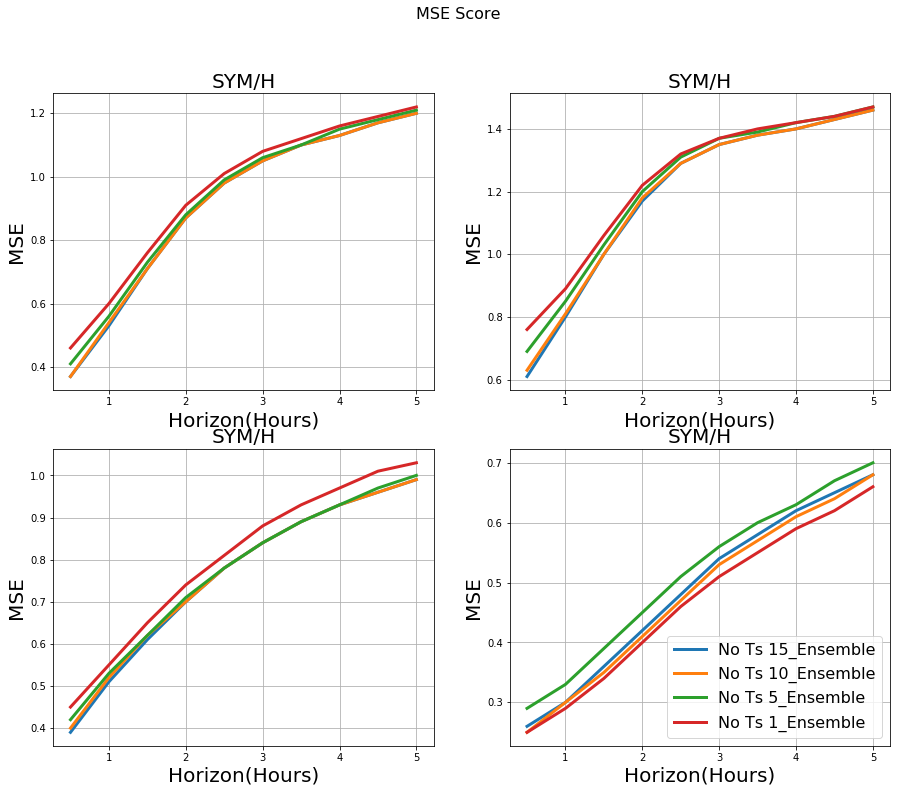

In [18]:
plotMet = 'MSE'

if(plotMet == 'R^2'):
    fig, axs = plt.subplots(2, 2, figsize=(15,12))
    axs = axs.ravel()
    legend = []
    for i in range(len(exps)):
        legend.append(desc[i] + ' ' + str(ensNum[i]) + '_Ensemble')
        for j in range(nT):
            axs[j].plot(np.linspace(res[i], len(trainLabels[0][0, :])*res[i], len(testLabels[0][0, :]))/60, 
                        testDF[tnames[j] + ' ' + plotMet].iloc[:, i], linewidth=3)
            axs[j].grid(axis='both', which='major', b=True)
            axs[j].set_ylabel(metName, fontsize=20)
            axs[j].set_xlabel('Horizon(Hours)', fontsize=20)
            axs[j].set_title(tnames[i], fontsize=20)
    axs[j].legend(legend, fontsize=16)
    fig.suptitle(metName + ' Score', fontsize=20)
    plt.show()
    fig.tight_layout()
else:
    fig,axs = plt.subplots(2, 2, figsize=(15, 12))
    axs = axs.ravel()
    legend = []
    for i in range(len(exps)):
        legend.append(desc[i] + ' ' + str(ensNum[i]) + '_Ensemble')
        for j in range(nT):
            axs[j].plot(np.linspace(res[i], len(trainLabels[0][0, :])*res[i], len(testLabels[0][0, :]))/60, 
                        testDF[tnames[j] + ' ' + plotMet].iloc[:, i], linewidth=3)
            axs[j].grid(axis='both', which='major', b=True)
            axs[j].set_ylabel(metName, fontsize=20)
            axs[j].set_xlabel('Horizon(Hours)', fontsize=20)
            axs[j].set_title(tnames[i], fontsize=20)
    axs[j].legend(legend, fontsize=16)
    fig.suptitle(plotMet + ' Score', fontsize=16)
    plt.show()
    fig.tight_layout()